Importing Libraries and Dependencies

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Importing necessary packages
import tempfile
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scripts.balanced_generator import BalanceCovidDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=15, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/model_plot.png", help="Path to save model's plot")
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument("--model_name", type=str, default="VGG16", help="Name of the model")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

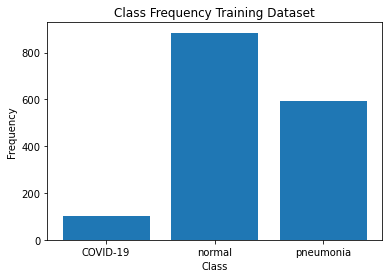

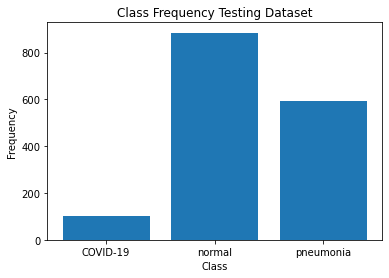

In [3]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Creating the model

In [4]:
# Method to add regularisation
def add_regularization(model, regularizer=regularizers.l2(0.0001)):

    if not isinstance(regularizer, regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # Load the model from the config
    model = model_from_json(model_json)

    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

def create_model():
    # Loading VGG16 model trained on imagenet without head
    baseModel = VGG16(
        weights="imagenet", include_top=False,
        input_tensor=Input(shape=(args.input_size, args.input_size,
                                  args.n_channels))
    )

    # Constructing the head for classification (to be trained)
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)

    # Fixing the weights of base model
    baseModel.trainable = False
    
    #  Adding regularisation
    model = Model(inputs=baseModel.input, outputs=headModel)
    model = add_regularization(model)
    return model

Hyperparameter search

In [5]:
# model = KerasClassifier(build_fn=create_model, verbose=0)
# batch_size = [8, 16, 32]
# epochs = [1, 2, 3]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X, Y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

model = create_model()

Instantiating data generators to load datasets

In [6]:
map = {
        'normal': 0,
        'pneumonia': 1,
        'COVID-19': 2
        }
test_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_test.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=1,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map,
        is_training=False,
        is_validation=False,
        is_testing=True
)


def get_model(df_trn, df_val):
    map = {
            'normal': 0,
            'pneumonia': 1,
            'COVID-19': 2
            }
    trn_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map
    )

    val_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_val.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map,
        is_training=False,
        is_validation=True
    )

    return model, trn_generator, val_generator

Training the model

[INFO] Training model
Epoch 1/15
1125/1125 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.9237
Epoch 00001: val_accuracy improved from -inf to 0.94043, saving model to saved_models/VGG16
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/VGG16/assets
1125/1125 [==============================] - 336s 298ms/step - loss: 0.4118 - accuracy: 0.9237 - val_loss: 0.3060 - val_accuracy: 0.9404
Epoch 2/15
1125/1125 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.9463
Epoch 00002: val_accuracy improved from 0.94043 to 0.95522, saving model to saved_models/VGG16
INFO:tensorflow:Assets written to: saved_models/VGG16/assets
1125/1125 [==============================] - 291s 258ms/step - loss: 0.3145 - accuracy: 0.9463 - val_loss: 0.2768 - val_accuracy: 0.9552
Epoch 3/15
1125/1125 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.9514
Epoch 00003: val_acc

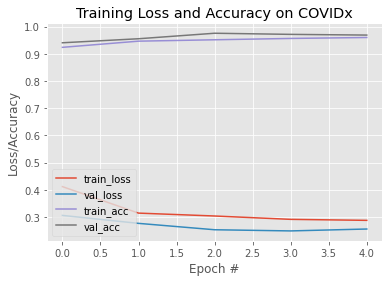

In [7]:
X_train, X_test, _, _ = train_test_split(df_train, df_train['class'], test_size=0.33, random_state=42)

# Getting model and generators fitted on ith fold data
model, train_generator, validation_generator = get_model(X_train, X_test)

# Compiling the model
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

train_classes = pd.DataFrame(train_generator.classes)
n_train = len(train_classes[train_classes.isin(['normal', 'pneumonia'])])

val_classes = pd.DataFrame(validation_generator.classes)
n_val = len(val_classes[val_classes.isin(['normal', 'pneumonia'])])

#print('n_train: {}, n_val:{}'.format(n_train,n_val))

# # Calculating class weights since COVID-19 data is very less
# class_weights = class_weight.compute_class_weight('balanced',
#                                                   classes,
#                                                   train_labels)
# cw = {}
# for i in range(0, 3):
#     cw.update({map.get(classes[i]): class_weights[i]})
class_weights = {0:1.0, 1:1.0, 2:3.0}


# CREATE CALLBACKS
checkpoint = ModelCheckpoint(args.model_dir+args.model_name, 
                        monitor='val_accuracy', verbose=1, 
                        save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
callbacks_list = [checkpoint, es]

# Training model
print("[INFO] Training model")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list)

# Plotting training loss and accuracy
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)

Evaluating the model and generating predictions

In [8]:
# Predicting on testing data
print("[INFO] Predicting on testing data")

nb_samples = len(df_test[df_test['class'].isin(['normal','pneumonia'])])
# Loading best model
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred = np.argmax(pred, axis=1)

# Getting class label map
temp = []
for i in test_labels:
    temp.append(map.get(i))

# Printing classification report
print(classification_report(temp, pred, target_names=map))

[INFO] Predicting on testing data
1579/1579 [==============================] - 56s 36ms/step
              precision    recall  f1-score   support

      normal       0.83      0.93      0.88       885
   pneumonia       0.90      0.53      0.67       594
    COVID-19       0.29      0.67      0.40       100

    accuracy                           0.76      1579
   macro avg       0.67      0.71      0.65      1579
weighted avg       0.82      0.76      0.77      1579



Printing confusion matrix

In [9]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(temp, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

[[827  32  26]
 [143 313 138]
 [ 31   2  67]]
Overall Accuracy: 0.7644
COVID Sensitivity: 0.9345
COVID Specificity: 0.7493


Plotting the training performance

ValueError: x and y must have same first dimension, but have shapes (15,) and (5,)

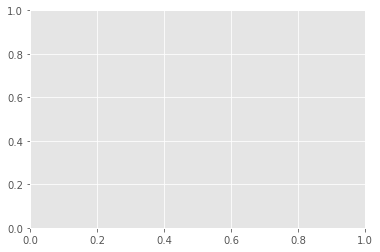

In [10]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)